In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner
from astropy.cosmology import Flatw0waCDM

In [9]:
# Astropy.cosmology version.Here I am using FlatwowaCDM because it has less parameters.(no Ode)
def Hz1(z1,H01,Om1,w01,wa1):
    cosmo =Flatw0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01,wa=wa1) 
    #the redshift dependence of the dark energy density:
    I = cosmo.de_density_scale(z1)
    E = np.sqrt((Om1*(1+z1)**3.) + (1.-Om1)*I)
    HZ1 = H01*E
    return HZ1

In [10]:
#Define  random redshifts
num_zs = 1000
zs= np.linspace(0.01,2.34, num=num_zs)

In [11]:
#From Planck observations for CPL mode
O_m=0.3029
w_0=-0.9414
w_1=-0.28
H_0=68.17

In [12]:
#Hubble comoving parameter
Hz=Hz1(zs,H_0,O_m,w_0,w_1)/(1+zs)

In [13]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)

In [14]:
H_zz= Hz + e1

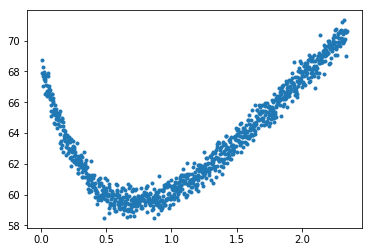

In [15]:
plt.plot(zs,H_zz, '.')

In [16]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.,True,50.,100.),
           ('w01',-1.,True,-3.,3.),
           ('wa1',0.1,True,-2.,2.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])/(1+zs)-H_zz)/error_sigma

In [17]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1000
    # variables        = 4
    chi-square         = 1027.44079
    reduced chi-square = 1.03156706
    Akaike info crit   = 35.0710432
    Bayesian info crit = 54.7020643
[[Variables]]
    Om1:  0.30468986 +/- 0.00170579 (0.56%) (init = 0.3)
    H01:  68.4212281 +/- 0.10861172 (0.16%) (init = 70)
    w01: -0.93121740 +/- 0.01170312 (1.26%) (init = -1)
    wa1: -0.33006169 +/- 0.05401939 (16.37%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om1, wa1) = -0.939
    C(w01, wa1) = -0.929
    C(Om1, w01) =  0.904
    C(H01, w01) = -0.874
    C(Om1, H01) = -0.856
    C(H01, wa1) =  0.724


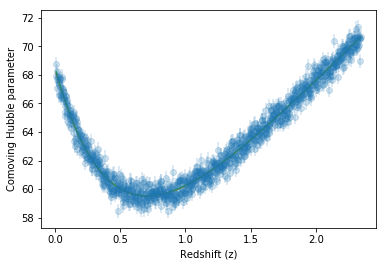

In [18]:
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01,bestwa1)/(1+zs))
plt.plot(zs,Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [19]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

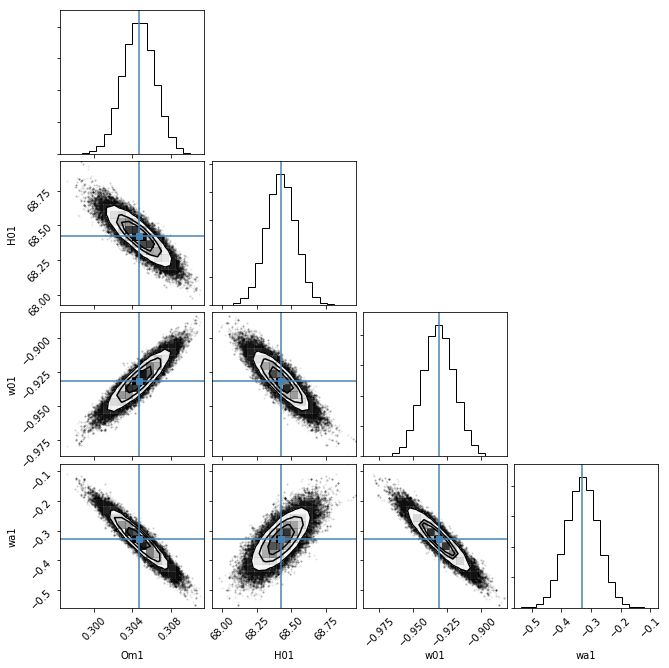

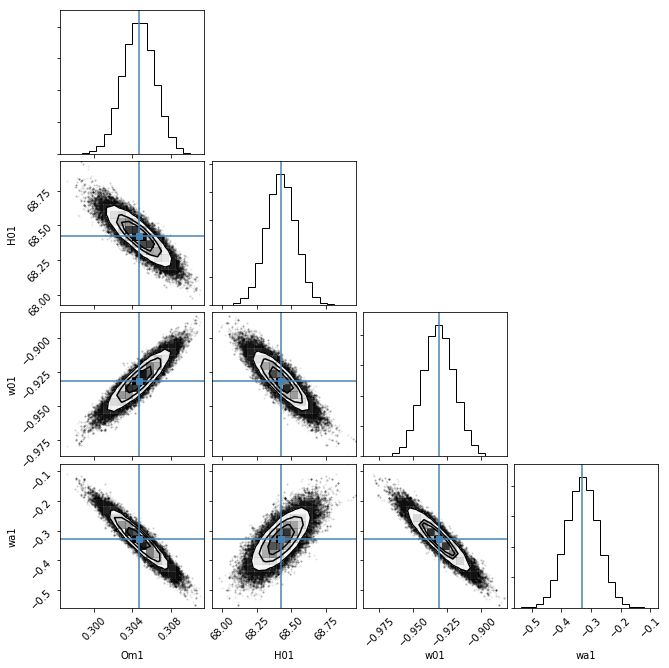

In [20]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))